# Pothole Localization

In [142]:
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np
import scipy
import cv2
import math
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET
%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import tensorflow.keras.utils
from sklearn.model_selection import train_test_split

### Loading Data

In [143]:
absFolder=os.getcwd()
parentFolder = os.path.dirname(absFolder)
dataFolder = os.path.join(parentFolder, 'NewData')
allImagesFolder = dataFolder
bag1Folder = os.path.join(dataFolder, 'Bag1')
bag2Folder = os.path.join(dataFolder, 'Bag2')
bag3Folder = os.path.join(dataFolder, 'Bag3')
bag4Folder = os.path.join(dataFolder, 'Bag4')
bag5Folder = os.path.join(dataFolder, 'Bag5')

# allImagesFolder = os.path.join(dataFolder, 'all')

In [144]:
# create a daraframe and load it with the labels from Pascal VOC xml files

labels = []


for bag in ['Bag1', 'Bag2', 'Bag3', 'Bag4', 'Bag5', 'RobotAvoid']:
    folderPath = os.path.join(dataFolder, bag)
    
    for filename in os.listdir(folderPath):
        if filename.endswith(".xml"):
            filepath = os.path.join(folderPath, filename)
            xml = ET.parse(filepath)
            annot = xml.getroot()
            fName = annot.find('filename').text
            size = annot.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            
            assert width > 0
            assert height > 0
            
            if width<40 or height<40 or width >999999 or height> 999999:
                continue
            
            imageFileName = os.path.join(folderPath, fName)
            
            objects = annot.findall('object')
            if len(objects)!=1:
                pass
            elif objects[0].find('name').text=='pothole':
                box = objects[0].find('bndbox')

                xmin = int(box.find("xmin").text)
                ymin = int(box.find("ymin").text)
                xmax = int(box.find("xmax").text)
                ymax = int(box.find("ymax").text)

                if xmin<0 or xmax>width or ymin<0 or ymax>height:
                    continue

                labels.append([fName, imageFileName, width, height, "pothole", xmin, ymin, xmax, ymax])

labelDf = pd.DataFrame(labels, 
                       columns=["filename", "imageFilePath", "width", 'height', "class", 'xmin', 'ymin', 'xmax', 'ymax'])


In [145]:
labelDf.describe()

,width,height,xmin,ymin,xmax,ymax
count,4248.0,4248.0,4248.000000,4248.000000,4248.000000,4248.000000
mean,640.0,480.0,187.844868,269.412665,464.484934,346.193032
std,0.0,0.0,147.016467,36.255749,136.885028,61.714191
min,640.0,480.0,1.000000,144.000000,64.000000,194.000000
25%,640.0,480.0,50.000000,255.000000,374.000000,310.000000
50%,640.0,480.0,177.000000,280.000000,459.500000,338.000000
75%,640.0,480.0,291.000000,294.000000,602.000000,375.000000
max,640.0,480.0,599.000000,367.000000,640.000000,480.000000


In [146]:
labelDf.tail(10)

,filename,imageFilePath,width,height,class,xmin,ymin,xmax,ymax
4238,frame1998.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,295,274,453,304
4239,frame2747.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,579,330,640,374
4240,frame2687.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,424,282,634,324
4241,frame1385.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,430,278,594,311
4242,frame1891.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,38,286,272,316
4243,frame4160.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,143,258,308,289
4244,frame1871.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,7,296,240,322
4245,frame0542.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,470,289,633,355
4246,frame0079.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,409,276,544,303
4247,frame2002.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,312,275,475,306


In [147]:
labelDf.isnull().sum()

filename         0
imageFilePath    0
width            0
height           0
class            0
xmin             0
ymin             0
xmax             0
ymax             0
dtype: int64

In [148]:
newSize = (128, 128)

labelDf.xmin = labelDf.xmin/labelDf.width
labelDf.xmax = labelDf.xmax/labelDf.width
labelDf.ymin = labelDf.ymin/labelDf.height
labelDf.ymax = labelDf.ymax/labelDf.height

labelDf['w'] = labelDf.xmax - labelDf.xmin
labelDf['h'] = labelDf.ymax - labelDf.ymin

In [149]:
labelDf.tail()

,filename,imageFilePath,width,height,class,xmin,ymin,xmax,ymax,w,h
4243,frame4160.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,0.223438,0.537500,0.481250,0.602083,0.257812,0.064583
4244,frame1871.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,0.010937,0.616667,0.375000,0.670833,0.364063,0.054167
4245,frame0542.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,0.734375,0.602083,0.989062,0.739583,0.254687,0.137500
4246,frame0079.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,0.639062,0.575000,0.850000,0.631250,0.210938,0.056250
4247,frame2002.jpg,/home/jupyter/Robo-Traverse/NewData/RobotAvoid...,640,480,pothole,0.487500,0.572917,0.742188,0.637500,0.254688,0.064583


In [150]:
def retrieveImage(fPath):
#     fPath = os.path.join(allImagesFolder, fName)
    pic = np.asarray(Image.open(fPath).convert('RGB').resize(newSize)) / 255.0
    return pic

In [151]:
# retrieve the images linked in the annotations
X = np.array(labelDf.imageFilePath.apply(retrieveImage).tolist())

In [152]:
Y = labelDf[['xmin', 'ymin', 'w', 'h']].to_numpy()

### Split data for training and testing

In [153]:
# do a random split to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=41)

In [154]:
# find the single images for testing and rest training
# test_indices = np.where(labelDf['imageFilePath'].str.contains('Robot'))
# train_indices = np.where(~labelDf['imageFilePath'].str.contains('Robot'))

# X_train = np.squeeze(np.take(X, train_indices, axis=0))
# Y_train = np.squeeze(np.take(Y, train_indices, axis=0))
# X_test = np.squeeze(np.take(X, test_indices, axis=0))
# Y_test = np.squeeze(np.take(Y, test_indices, axis=0))

In [155]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3398, 128, 128, 3)
(3398, 4)
(850, 128, 128, 3)
(850, 4)


### Data Augmentation

In [156]:
def move_to_center(point):
    x = point[0] - 0.5
    y = 0.5 - point[1]
    
#     print("Centered:", end=' ')
#     print([x,y])
    return [x,y] # TODO make ndarray
def convert_to_polar(vec):
    r1 = math.sqrt(vec[0]**2+vec[1]**2)
    theta1 = math.atan2(vec[1],vec[0])
    vec[0], vec[1] = r1, theta1
#     print("Polar:", end=' ')
#     print(vec)
    return vec
def rotate(vec, deg):
    rads = math.radians(deg)
    vec[1] = vec[1] + rads
#     print("Rotated:", end=' ')
#     print(vec)
    return vec
def convert_cartesian(vec):
    vec[0], vec[1] = vec[0]*math.cos(vec[1]), vec[0]*math.sin(vec[1])
#     print("Cartesian:", end=' ')
#     print(vec)
    return vec
def move_upper_left(vec):
    vec[0] = vec[0] + 0.5
    vec[1] = 0.5 - vec[1]
#     print("Back to top left:", end=' ')
#     print(vec)
    return vec

In [157]:
def rotate_coords(box, deg):
#     print(box)
#     print('\n')
#     print("Doing top left...")
    topLeft = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0], box[1]])), deg)))
#     print("Doing top right...")
    topRight = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0]+box[2], box[1]])), deg)))
    bottomLeft = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0], box[1]+box[3]])), deg)))
    bottomRight = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0]+box[2], box[1]+box[3]])), deg)))
    
    nx = min(topLeft[0], topRight[0], bottomLeft[0], bottomRight[0])
    ny = min(topLeft[1], topRight[1], bottomLeft[1], bottomRight[1])
    nw = max(topLeft[0], topRight[0], bottomLeft[0], bottomRight[0]) - nx
    nh = max(topLeft[1], topRight[1], bottomLeft[1], bottomRight[1]) - ny
    
#     nx = 10/128
#     ny = 10/128
#     nw = 30/128
#     nh = 30/128
    
    box[0], box[1], box[2], box[3] = nx, ny, nw, nh
#     print(box)
    return box

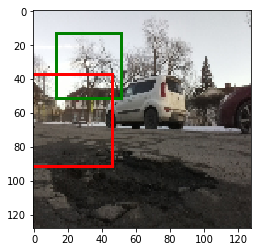

In [158]:
# show that the rotation is working. 
box1 = np.array([.10, .10, .30, .30])

fig = plt.figure()
plt.imshow(X[4])
a1 = plt.gca()
rect = pat.Rectangle((box1[0]*128.0,box1[1]*128.0),box1[2]*128.0,box1[3]*128.0, linewidth = 3, edgecolor='g', facecolor='none')
a1.add_patch(rect)

rotatedBox = rotate_coords(box1, 45) * 128.0
rect = pat.Rectangle((rotatedBox[0],rotatedBox[1]),rotatedBox[2],rotatedBox[3], linewidth = 3, edgecolor='r', facecolor='none')
a1.add_patch(rect)

In [159]:
max_brightness_factor = 0.2
max_rotation_angle = 40
max_shift = 0.15

class PotholeBatchGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, 
                x_set,
                y_set,
                batch_size,
                image_dims=newSize,
                 shuffle=True,
                 num_channels=3,
                 num_outputs=4,
                 is_train=True):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dims = image_dims
        self.shuffle=shuffle
        self.num_channels = num_channels
        self.num_outputs = num_outputs
        self.num_images = self.x.shape[0]
        self.indexes = np.arange(self.num_images)
        self.is_train = is_train
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(self.num_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.num_images)
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dims, self.num_channels))
        y = np.empty((self.batch_size, self.num_outputs))
        
        for i in range(self.batch_size):
            y[i,:] = self.y[batch_indexes[i],:]
            
            flip_flag = np.random.randint(2)
            if flip_flag ==1 and self.is_train:
                x[i, :, :, :] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
                y[i, 0] = 1-y[i, 0] - y[i, 2]
            else:
                x[i, :, :, :] = self.x[batch_indexes[i],:,:,:]
                
            
            
            
            if self.is_train:
                brightness_mult = np.random.random()*max_brightness_factor*2 - max_brightness_factor + 1
                x[i,:,:,:] = brightness_mult * x[i,:,:,:]
                
        if self.is_train:
            angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
            
            for i in range(self.batch_size):
                y[i, :] = rotate_coords(y[i, :], angle)
            x = scipy.ndimage.interpolation.rotate(x, angle, (2,1), False, mode="constant", cval=0, order=0)
            
            shift = np.random.random()*2*max_shift - max_shift
#             shift=0.2
            M = np.float32([[1,0,shift*newSize[0]], [0,1,0]])
            
#             x = scipy.ndimage.interpolation.shift(x, (0, 0, shift*newSize[0],  0), mode="constant", cval=0)
            for i in range(self.batch_size):
                y[i, 0] += shift
                x[i] = cv2.warpAffine(x[i], M, newSize)
            
        else:
            angle = 0
            shift = 0
        
        
        
        return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(38.713874147122624, 60.802144618886274, 42.37947971785141, 27.740828380563315)
(20.877283861246486, 86.56340372122358, 33.78944143846497, 20.100054181069254)
(43.812430442353005, 72.6715378107093, 69.96110773116874, 28.942907226344403)
(54.6054012722976, 70.48723597401258, 69.13787498058629, 40.56003004908871)
(55.504871219775836, 67.76760482601304, 80.88963416603974, 37.12356395626372)
(32.928643515927874, 73.93982817292394, 37.057225880391684, 19.87054990760295)
(71.33474004763971, 66.60241256254741, 73.94873554699583, 31.831387160190815)
(20.72748362663253, 86.4779765186085, 42.05038717955677, 34.3063907383293)


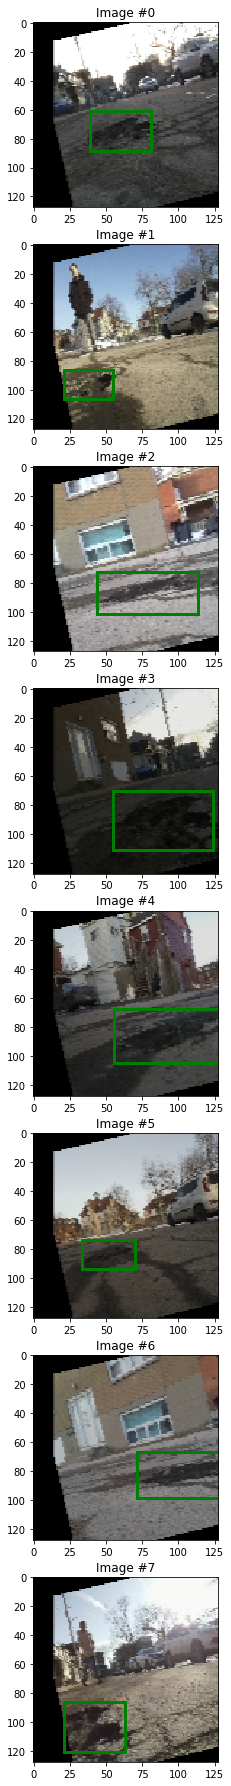

In [160]:
# looking at batch generator

batch_size = 16
num_show=8

gen = PotholeBatchGenerator(X, Y, batch_size, shuffle=True, is_train=True)

bx, by = gen.__getitem__(0)
# print(bx.shape)

i = np.random.randint(batch_size)

fig = plt.figure(figsize=(18,4*num_show))
for i in range(num_show):
    
    [x,y,w,h] = by[i,:]
    
#     print("Y labels:")
#     print((x,y,w,h))
#     print("Sample of X values:")
#     print(bx[i,60,30])
    
    x = x*newSize[0]
    y = y*newSize[1]
    w = w*newSize[0]
    h = h*newSize[1]
    
    
    
    a1 = fig.add_subplot(num_show, 3, i*3+1)
    img1 = a1.imshow(bx[i,:,:,:])
    a1.set_title("Image #{}".format(i))
    rect = pat.Rectangle((x,y),w,h, linewidth = 3, edgecolor='g', facecolor='none')
    print((x,y,w,h))
    a1.add_patch(rect)


### Model design

In [161]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(newSize[0],newSize[1], 3), activation='relu'))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout(0.05))

# model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.05))

# model.add(Conv2D(64, (2,2), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.1))

# model.add(Conv2D(128, (2,2), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.15))

# model.add(Conv2D(256, (2,2), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.20))

model.add(Dense(128))

model.add(Flatten())
model.add(Dense(4))
model.add(Activation('linear'))



In [162]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 28, 28, 64)       

In [163]:
model.compile(optimizer= 'adam', loss='mean_squared_error')

In [164]:
train_gen = PotholeBatchGenerator(X_train, Y_train, 8)
test_gen = PotholeBatchGenerator(X_test, Y_test, 8, is_train=False)

In [165]:
history = model.fit_generator(train_gen, validation_data=test_gen, epochs=20)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 424 steps, validate for 106 steps
Epoch 1/20
424/424 [==============================] - 15s 36ms/step - loss: 0.0281 - val_loss: 0.0144
Epoch 2/20
424/424 [==============================] - 14s 33ms/step - loss: 0.0160 - val_loss: 0.0106
Epoch 3/20
424/424 [==============================] - 14s 33ms/step - loss: 0.0129 - val_loss: 0.0072
Epoch 4/20
424/424 [==============================] - 14s 34ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 5/20
424/424 [==============================] - 14s 33ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 6/20
424/424 [==============================] - 14s 32ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 7/20
424/424 [==============================] - 14s 32ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 8/20
424/424 [==============================] - 14s 32ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 9/20
424/424 [==============================] - 14s 32ms/step - loss: 0.0061 - val_l

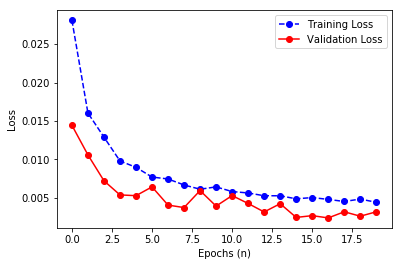

In [166]:
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'] ,'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

## Visualize results

(0.2, 2.7206125259399414)
(82.93333333333334, 73.68412780761719)
(82.8, 81.6783218383789)
(33.06666666666666, 47.93382263183594)


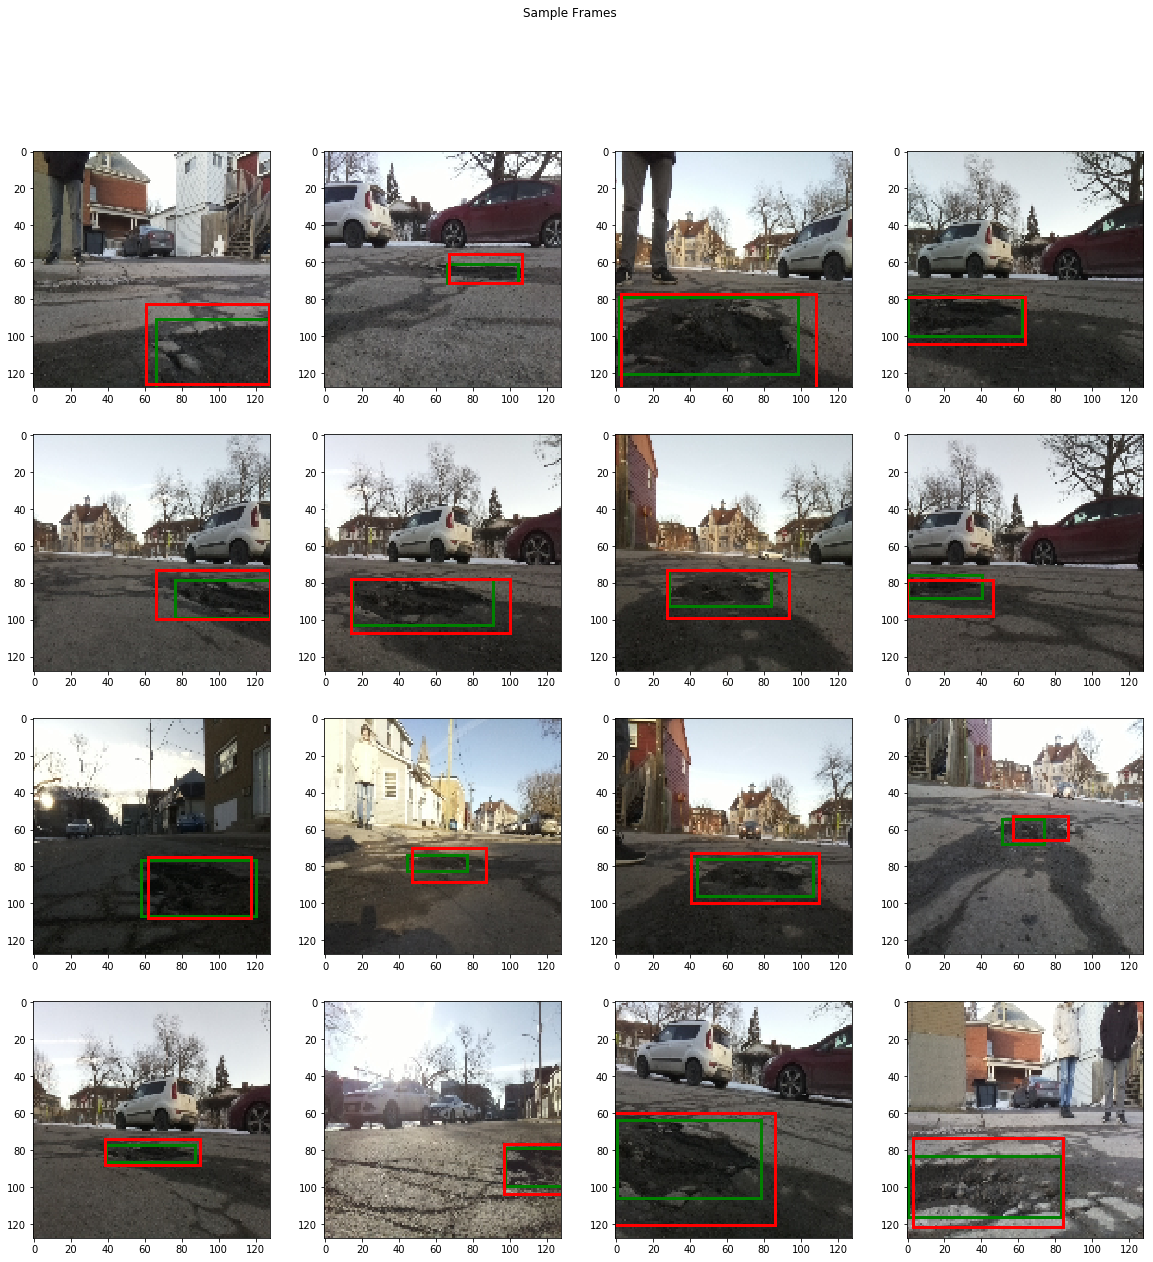

In [167]:
shift = 26
sampleNum = 16
fig, axs = plt.subplots(sampleNum//4, 4, figsize=(20,20))
fig.suptitle("Sample Frames")

for imgNum in range(sampleNum):
    plt.imshow(X_test[imgNum])
    axs[imgNum//4][imgNum%4].imshow(X_test[20+imgNum + shift])
    
    
    [x,y,w,h] = Y_test[20+imgNum + shift]
    [[x1,y1,w1,h1]] = model.predict(np.expand_dims(X_test[20+imgNum + shift], axis=0))
    
    x = x*newSize[0]
    y = y*newSize[1]
    w = w*newSize[0]
    h = h*newSize[1]

    x1= x1*newSize[0]
    y1= y1*newSize[1]
    w1= w1*newSize[0]
    h1= h1*newSize[1]

    rect = pat.Rectangle((x,y),w,h, linewidth = 3, edgecolor='g', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect)
    rect1 = pat.Rectangle((x1,y1),w1,h1, linewidth = 3, edgecolor='r', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect1)
print((x,x1))
print((y,y1))
print((w,w1))
print((h,h1))

In [169]:
from datetime import datetime
timeStamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_file_path = os.path.join(absFolder, "model_" + timeStamp +"-demo1"+ ".h5")
model.save(model_file_path)
print("Model saved to {}".format(model_file_path))

Model saved to /home/jupyter/Robo-Traverse/Notebooks/model_2020-03-05_21-40-27-demo1.h5
